<a href="https://colab.research.google.com/github/nanom/textMining2021/blob/main/proy_final/second_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Environment config

#### 1.1 Check GPU device capabilities

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



#### 1.2 Installations of libs (Assure set enviroment to work on GPU)

In [ ]:
# Install libs
!pip install -U pip setuptools wheel --quiet
!pip install -U spacy[cuda101] --quiet
!python -m spacy download en_core_web_md --quiet
!pip install contractions --quiet
! pip install fasttext --quiet

#### 1.3 Import libs

In [ ]:
# --- Import libs ---
import spacy
import contractions as ctr
from spacy.matcher import PhraseMatcher

import pandas as pd
import random
import numpy as np
from tqdm import tqdm
from collections import Counter

# Plotting libs
import seaborn as snb
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
import plotly.graph_objs as go

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import preprocessing, feature_selection, metrics

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


#### 1.4 Drive access and gral config

In [ ]:
# --- Acceso a drive ---
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# --- Files Path ----
PATH = "/content/gdrive/MyDrive/Doctorado/cursos_posgrado/textMining2021/proy_final/"
SOURCE_FOLDER = PATH + "source/"
OUT_DFS_FOLDER = PATH + "out_dataframes/"


# --- Visual pandas proggress ---
tqdm.pandas()

 # --- Enable spacy gpu ---
try:
    print("SpaCy GPU available? {}".format(spacy.require_gpu()))
    # print("SpaCy GPU available? {}".format(spacy.prefer_gpu()))
except:
    print("GPU not available. Spacy will work with CPU.")

Mounted at /content/gdrive
GPU not available. Spacy will work with CPU.


# 2) Generate corpus of questions and answers
---



In [ ]:
# Load test, val and train VizWiz-VQA datasets
train = pd.read_json(SOURCE_FOLDER+"train.json")
val = pd.read_json(SOURCE_FOLDER+"val.json")
test = pd.read_json(SOURCE_FOLDER+"test.json")

In [ ]:
# Generate corpus of questions and answers_list (Use validation and training sets because val set no containt answerss) 
raw_corpus = pd.concat([train[['question','answers']], val[['question','answers']]])

## Convert list of dic answers to list of unique answers 
raw_corpus['answers'] = raw_corpus.answers.progress_apply(lambda x: [v for dic in x for k,v in dic.items() if k == 'answer'])

### Sort answers list by agreement 
raw_corpus['answers'] = raw_corpus.answers.progress_apply(lambda x: Counter(x).most_common())

## Expand contractions of questions
raw_corpus['question'] = raw_corpus.question.progress_apply(lambda qs: ctr.fix(qs).lower().strip())

## Delete questions duplicate
raw_corpus = raw_corpus.drop_duplicates(subset="question")

## Add number of sentence that contain each question
pln = spacy.load('en_core_web_md')
raw_corpus = raw_corpus.assign(num_sents=raw_corpus.question.progress_apply(lambda qs: len(list(pln(qs).sents))))

## Filter question with more that one sentence
_total = len(raw_corpus)
raw_corpus = raw_corpus[raw_corpus.num_sents == 1]
_one_sent = len(raw_corpus)
print("\nNumber of questions with only one sent: {}/{} ({:.2f}%)".format(_one_sent, _total, _one_sent*100/_total))


# Save dataframe
raw_corpus = raw_corpus[['question', 'answers']]
raw_corpus.reset_index(inplace=True, drop=True)
raw_corpus.to_pickle(OUT_DFS_FOLDER+"raw_corpus.pkl")

#  Test
print("{} questions retrieved!".format(len(raw_corpus)))
raw_corpus

100%|██████████| 11852/11852 [01:44<00:00, 113.39it/s]



Number of questions with only one sent: 9003/11852 (75.96%)
9003 questions retrieved!


,question,answers
0,what is the name of this product?,"[(basil leaves, 7), (basil, 3)]"
1,can you tell me what is in this can please?,"[(coca cola, 3), (unsuitable, 2), (coke 0, 2),..."
2,what is the captcha on this screenshot?,"[(t36m, 8), (t 3 6 m, 1), (t63m, 1)]"
3,what is this item?,"[(solar garden light, 8), (solar light, 1), (g..."
4,what is this?,"[(shoes, 4), (boots, 2), (feet, 2), (unanswera..."
...,...,...
8998,and how big is it?,"[(unanswerable, 4), (about 32 inches, 1), (32 ..."
8999,how many tablets are in this box?,"[(8, 8), (8 tablets, 2)]"
9000,what is this in front of the camera?,"[(computer, 3), (laptop, 1), (computer monitor..."
9001,is this modern?,"[(unsuitable, 7), (no, 1), (unanswerable, 1), ..."


#### 2.1) Add column with question's lemmas, PoS and tokens. Add columns with answers lemmatization and tokens

In [ ]:
# Load spacy model to generate token and PoS by each questions and answers
pln = spacy.load('en_core_web_md')

def question2PosAndTokens(question):
    # Only get alphabetic tokens
    doc = pln(question)
    tks_list, lemma_list, pos_list = ['CLS'], ['CLS'], ['CLS']
    for tk in doc:
        if tk.is_alpha:
            pos_list.append(tk.pos_)
            lemma_list.append(tk.lemma_.lower())
            tks_list.append(tk.text.lower())
    tks_list.append('SEP')
    lemma_list.append('SEP')
    pos_list.append('SEP')
    return tks_list, lemma_list, pos_list

def ans2Tokens(ans_list):
    tks_list, lemma_list = [], []
    for ans in ans_list:
        temp_tokens = [tk.text.lower() for tk in pln(ans[0])]
        temp_lemmas = [tk.lemma_.lower() for tk in pln(ans[0])]
        
        tks_list.append(temp_tokens+['SEP'])
        lemma_list.append(temp_lemmas+['SEP'])
    return tks_list, lemma_list

# Test functions
q1 = "Can you tell me what is in this can please?"
ans1 = [('basil leaves', 7), ('basil', 2), ('t63m', 1)]
r = question2PosAndTokens(q1)
a = ans2Tokens(ans1)

print("Q1: {}".format(q1))
print("\t tokens -> {}".format(r[0]))
print("\t lemmas -> {}".format(r[1]))
print("\t pos -> {}".format(r[2]))
print("Ans: {}".format(ans1))
print("\t tokens -> {}".format(a[0]))
print("\t lemmas -> {}".format(a[1]))

Q1: Can you tell me what is in this can please?
	 tokens -> ['CLS', 'can', 'you', 'tell', 'me', 'what', 'is', 'in', 'this', 'can', 'please', 'SEP']
	 lemmas -> ['CLS', 'can', 'you', 'tell', 'i', 'what', 'be', 'in', 'this', 'can', 'please', 'SEP']
	 pos -> ['CLS', 'AUX', 'PRON', 'VERB', 'PRON', 'PRON', 'AUX', 'ADP', 'PRON', 'AUX', 'VERB', 'SEP']
Ans: [('basil leaves', 7), ('basil', 2), ('t63m', 1)]
	 tokens -> [['basil', 'leaves', 'SEP'], ['basil', 'SEP'], ['t63', 'm', 'SEP']]
	 lemmas -> [['basil', 'leave', 'SEP'], ['basil', 'SEP'], ['t63', 'm', 'SEP']]


In [ ]:
# # Load corpus
raw_corpus = pd.read_pickle(OUT_DFS_FOLDER+"raw_corpus.pkl")

# Add column with tokens lemmas and PoS for each question
raw_corpus = raw_corpus.assign(temp=raw_corpus.question.progress_apply(lambda qs: question2PosAndTokens(qs)))
raw_corpus = raw_corpus.assign(qs_tks=raw_corpus.temp.progress_apply(lambda x: x[0]))
raw_corpus = raw_corpus.assign(qs_lemmas=raw_corpus.temp.progress_apply(lambda x: x[1]))
raw_corpus = raw_corpus.assign(qs_pos=raw_corpus.temp.progress_apply(lambda x: x[2]))
raw_corpus.drop(columns={'temp'}, inplace=True)

# Add column with tokens list for each answer
raw_corpus = raw_corpus.assign(temp=raw_corpus.answers.progress_apply(lambda ans: ans2Tokens(ans)))
raw_corpus = raw_corpus.assign(ans_tks=raw_corpus.temp.progress_apply(lambda x: x[0]))
raw_corpus = raw_corpus.assign(ans_lemmas=raw_corpus.temp.progress_apply(lambda x: x[1]))
raw_corpus.drop(columns={'temp'}, inplace=True)

# Save new corpus
raw_corpus.to_pickle(OUT_DFS_FOLDER+'proc_corpus.pkl')
raw_corpus

#3) Filter trivial information (PhraseMatcher)

In [ ]:
# Load corpus
corpus = pd.read_pickle(OUT_DFS_FOLDER+"proc_corpus.pkl")

# Matcher
pln = spacy.load('en_core_web_md')
phrase_matcher = PhraseMatcher(pln.vocab)

phrases = [ 'can you tell me',
            'can you tell',
            'tell me',
            'please tell me',
            'can you please tell me',
            'please can you tell me',
            'could you please tell me',
            'can you please',
            'can you read to me', 
            'can you please read', 
            'can you see',
            'can you read',
            'can you give me',
            'can you help me', 
           ]

patterns = [pln(text) for text in phrases]
phrase_matcher.add('trivial_information', None, *patterns)
print(patterns)

def phrasesMatchedIndex(doc):
    start, end = len(doc) + 1, 0
    matched_phrases = phrase_matcher(doc)
    if matched_phrases:
        _, start, end = max(matched_phrases, key=lambda tup: tup[2] - tup[1])
    return [start, end]

def question2Lemmas(question):
    # Only get alphabetic tokens
    doc = pln(question)
    start, end = phrasesMatchedIndex(doc)
    # print(start,end)

    lemma_list = ['CLS']
    for tk in doc:
        if tk.is_alpha and (tk.i < start or tk.i >= end):
            # print(tk.text, tk.i)
            lemma_list.append(tk.lemma_.lower())
    lemma_list.append('SEP')
    return lemma_list

# Test
qs1 = "can you tell me what is in this can please?"
print(question2Lemmas(qs1))
qs2 = "hi, what is in this can please?"
print(question2Lemmas(qs2))

[can you tell me, can you tell, tell me, please tell me, can you please tell me, please can you tell me, could you please tell me, can you please, can you read to me, can you please read, can you see, can you read, can you give me, can you help me]
['CLS', 'what', 'be', 'in', 'this', 'can', 'please', 'SEP']
['CLS', 'hi', 'what', 'be', 'in', 'this', 'can', 'please', 'SEP']


In [ ]:
# Filter trivial info in corpus
wotinfo_corpus = corpus.assign(qs_lemmas_wotinfo = corpus.question.progress_apply(lambda qs: question2Lemmas(qs)))

# Save new corpus
wotinfo_corpus = wotinfo_corpus[['question', 'answers', 'qs_tks', 'qs_lemmas', 'qs_lemmas_wotinfo', 'qs_pos', 'ans_tks','ans_lemmas']]
wotinfo_corpus.to_pickle(OUT_DFS_FOLDER+'wotinfo_corpus.pkl')
wotinfo_corpus

100%|██████████| 9003/9003 [01:14<00:00, 121.00it/s]


,question,answers,qs_tks,qs_lemmas,qs_lemmas_wotinfo,qs_pos,ans_tks,ans_lemmas
0,what is the name of this product?,"[(basil leaves, 7), (basil, 3)]","[CLS, what, is, the, name, of, this, product, ...","[CLS, what, be, the, name, of, this, product, ...","[CLS, what, be, the, name, of, this, product, ...","[CLS, PRON, AUX, DET, NOUN, ADP, DET, NOUN, SEP]","[[basil, leaves, SEP], [basil, SEP]]","[[basil, leave, SEP], [basil, SEP]]"
1,can you tell me what is in this can please?,"[(coca cola, 3), (unsuitable, 2), (coke 0, 2),...","[CLS, can, you, tell, me, what, is, in, this, ...","[CLS, can, you, tell, i, what, be, in, this, c...","[CLS, what, be, in, this, can, please, SEP]","[CLS, AUX, PRON, VERB, PRON, PRON, AUX, ADP, P...","[[coca, cola, SEP], [unsuitable, SEP], [coke, ...","[[coca, cola, SEP], [unsuitable, SEP], [coke, ..."
2,what is the captcha on this screenshot?,"[(t36m, 8), (t 3 6 m, 1), (t63m, 1)]","[CLS, what, is, the, captcha, on, this, screen...","[CLS, what, be, the, captcha, on, this, screen...","[CLS, what, be, the, captcha, on, this, screen...","[CLS, PRON, AUX, DET, NOUN, ADP, DET, NOUN, SEP]","[[t36, m, SEP], [t, 3, 6, m, SEP], [t63, m, SEP]]","[[t36, m, SEP], [t, 3, 6, m, SEP], [t63, m, SEP]]"
3,what is this item?,"[(solar garden light, 8), (solar light, 1), (g...","[CLS, what, is, this, item, SEP]","[CLS, what, be, this, item, SEP]","[CLS, what, be, this, item, SEP]","[CLS, PRON, AUX, DET, NOUN, SEP]","[[solar, garden, light, SEP], [solar, light, S...","[[solar, garden, light, SEP], [solar, light, S..."
4,what is this?,"[(shoes, 4), (boots, 2), (feet, 2), (unanswera...","[CLS, what, is, this, SEP]","[CLS, what, be, this, SEP]","[CLS, what, be, this, SEP]","[CLS, PRON, AUX, PRON, SEP]","[[shoes, SEP], [boots, SEP], [feet, SEP], [una...","[[shoe, SEP], [boot, SEP], [foot, SEP], [unans..."
...,...,...,...,...,...,...,...,...
8998,and how big is it?,"[(unanswerable, 4), (about 32 inches, 1), (32 ...","[CLS, and, how, big, is, it, SEP]","[CLS, and, how, big, be, it, SEP]","[CLS, and, how, big, be, it, SEP]","[CLS, CCONJ, SCONJ, ADJ, AUX, PRON, SEP]","[[unanswerable, SEP], [about, 32, inches, SEP]...","[[unanswerable, SEP], [about, 32, inch, SEP], ..."
8999,how many tablets are in this box?,"[(8, 8), (8 tablets, 2)]","[CLS, how, many, tablets, are, in, this, box, ...","[CLS, how, many, tablet, be, in, this, box, SEP]","[CLS, how, many, tablet, be, in, this, box, SEP]","[CLS, SCONJ, ADJ, NOUN, AUX, ADP, DET, NOUN, SEP]","[[8, SEP], [8, tablets, SEP]]","[[8, SEP], [8, tablet, SEP]]"
9000,what is this in front of the camera?,"[(computer, 3), (laptop, 1), (computer monitor...","[CLS, what, is, this, in, front, of, the, came...","[CLS, what, be, this, in, front, of, the, came...","[CLS, what, be, this, in, front, of, the, came...","[CLS, PRON, AUX, PRON, ADP, NOUN, ADP, DET, NO...","[[computer, SEP], [laptop, SEP], [computer, mo...","[[computer, SEP], [laptop, SEP], [computer, mo..."
9001,is this modern?,"[(unsuitable, 7), (no, 1), (unanswerable, 1), ...","[CLS, is, this, modern, SEP]","[CLS, be, this, modern, SEP]","[CLS, be, this, modern, SEP]","[CLS, AUX, DET, NOUN, SEP]","[[unsuitable, SEP], [no, SEP], [unanswerable, ...","[[unsuitable, SEP], [no, SEP], [unanswerable, ..."


# 4) Select random questions pair to test clustering models

In [ ]:
def createQuestionsPair(n_qs):

    # Load corpus
    corpus = pd.read_pickle(OUT_DFS_FOLDER+"wotinfo_corpus.pkl")
    questions_tup = []
    i = n_qs
    eq, neq = 0, 0

    while i > 0:
        sample1 = corpus.sample(1)
        qs1 = sample1.question.values[0]
        sample2 = corpus.sample(1)
        qs2 = sample2.question.values[0]


        print("\n[{}/{}] - No={} Yes={}\n---------------".format(n_qs - i,n_qs, neq, eq))
        print("*{}\n*{}".format(qs1, qs2))
        
        same_cluster = 'x'
        while same_cluster not in ['0','1','s']:
            same_cluster = input("Same cluster? [yes(1) | no(0) | skip('s')] > ")

        if same_cluster == 's':
            continue
        elif same_cluster == '0':
            neq += 1
        elif same_cluster == '1':
            eq += 1

        corpus = corpus.drop(sample1.index)
        corpus = corpus.drop(sample2.index)

        questions_tup.append([qs1,qs2,int(same_cluster)])
        i -= 1

        # save test df
        test_df = pd.DataFrame(questions_tup, columns={'qs1', 'qs2', 'same_cluster'}) 
        test_df.to_pickle(OUT_DFS_FOLDER+'test_df.pkl')

    return testdf

In [ ]:
# Create dataframe
createQuestionsPair(224)

,qs1,qs2,same_cluster
0,what is the name of this packet of chocolates?,what does this bag say?,True
1,what kind of tracing is this?,what is the number on the back of this card?,False
2,type of soda is this?,what kind of goldfish crackers are these?,True
3,what beer is this?,can you tell me what is this?,False
4,what is on this side of the bottle?,what does this jar say on it?,False
...,...,...,...
208,does this onion look okay,is this vanilla coffee?,True
209,what color are these slacks?,what color are those shorts?,True
210,what color is this pillow?,this is an advertisement?,True
211,what color is my hand?,what color is this tablet?,True


# 5) Clustering

#### 5.0-  Main functions

In [ ]:
# Functions
def normAndReduction(features, _threshold_var=.001, _reduction=True):

    # Normalization by examples due the distribution of frequency words is exponential
    features = preprocessing.normalize(features, axis=1, norm='l2')
    print("Features dimensionality post Normalization: {}".format(features.shape))

    if _reduction:
        # Decrease in dimensionality by variance threshold. That is: I remove features (columns) 
        # with very low variability (less than '_threshold_var').
        selector = feature_selection.VarianceThreshold(_threshold_var)
        features = selector.fit_transform(features)

        print("Post (Norm + Dimensionality reduction): {}".format(features.shape))

    return pd.DataFrame(features)

def myKmeans(corpus, features, k, max_iter=300, n_init=10, debug=True):
    """
    Search clusters using Kmenas method
    """

    # -- Set kmeans model, and fit ---
    model = KMeans(     n_clusters=k,
                        max_iter=max_iter, 
                        n_init=n_init, 
                        verbose=False).fit(features)

    # --- Create dataframe with questions, answers, lables and distances ---
    ## Puting labels and calculate distances from each sample in referent your centroids
    distances = []
    labels = model.labels_

    for ith, dist in enumerate(model.transform(features)):
        distances.append(dist[labels[ith]])
    distances = np.array(distances)

    ## Generate dataframe
    data = corpus[['question', 'answers']].assign(labels=labels, dist=distances)

    if debug: print(Counter(labels))

    return model, data


# Test clustering
def getClustersMetrics(corpus, features, k_init=10, k_end=30, debug=True):

    # Load pair questions to testing clustering results 
    test_df = pd.read_pickle(OUT_DFS_FOLDER+'test_df.pkl')

    # Test number of clusters to use k=10,..,30
    results = []
    for k in range(k_init, k_end + 1):
        model, data = myKmeans(corpus, features, k, debug=False)
    
        # Calculation of accuracy to pairs of questions marked as same and different clusters for each cluster# Calculate of pair marker to same and different clusters for eahc cluster execute
        data_same = []
        for _,row in test_df.iterrows():
            is_same = data[data.question == row['qs1']].labels.values[0] == data[data.question == row['qs2']].labels.values[0]
            data_same.append(int(is_same))

        stat = test_df.assign(d_same_cluster=data_same)
        accuracy_same = stat[stat.same_cluster == 1].d_same_cluster.mean()
        accuracy_diff = 1 - stat[stat.same_cluster == 0].d_same_cluster.mean()

        results.append([k, accuracy_same*100, accuracy_diff*100])
        if debug:
            print("Clustering using k:{} - Same={:.2f}% - Diff:{:.2f}%".format(k, accuracy_same*100, accuracy_diff*100))
    
    # Convert list of results to dataframe
    df = pd.DataFrame(results)
    df.rename(columns={0:'Clusters',1:'same_clusters',2:'diff_clusters'}, inplace=True)

    fig, ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=((k_end - k_init + 1) * 1.3, 8))
    g1 = snb.barplot(data=df,x='Clusters', y='same_clusters', ax=ax[0])
    g2 = snb.barplot(data=df,x='Clusters', y='diff_clusters', ax=ax[1])
    
    
    for p in g1.patches:
        g1.annotate( str(round(p.get_height(),2 ))+"%",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', size=14, xytext=(0, -12),textcoords='offset points')
    
    for p in g2.patches:
        g2.annotate( str(round(p.get_height(),2 ))+"%",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', size=14, xytext=(0, -12),textcoords='offset points')
#   
    g1.set(xlabel=None)
    g2.set_xlabel("Number of clusters (k)")
    g1.set_ylabel("Accuracy (%)")
    g2.set_ylabel("Accuracy (%)")
    g1.set(title="Questions in Same clusters")
    g2.set(title="Questions in Different clusters")
    plt.show()

def getQuestionByClusters(data, top=20):
    from tabulate import tabulate
    
    limit_to_print = 70
    for l in sorted(data.labels.unique()):
        print("\n[Cluster {}] --- {} top questions".format(l, top))
        df = data[data.labels == l].sort_values(by='dist').head(top)
        
        # Cut long questions
        fcut_qs = lambda qs: qs[:limit_to_print]+"..." if len(qs) > limit_to_print else qs 
        df = df.assign(question=df.question.apply(lambda qs: fcut_qs(qs)))

        # Leave only most agreement answer
        df = df.assign(top_ans=df.answers.apply(lambda ans_list: ans_list[0][0]))[['question','top_ans', 'dist']]
        print(tabulate(df, headers='keys', tablefmt='psql', showindex='False'))
        print("")

def silhouettePlot(km_model):
    # Config fig
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # --- Plot Silhouette ---
    visualizer = SilhouetteVisualizer(km_model,  colors='yellowbrick', ax=ax)
    
    # Fit the data to the visualizer
    visualizer.fit(features)

def clustersVisualizer(data, features, top=None):
    """
    Plot the top question most closed to each centroide
    """

    def generateColors(N):
        import colorsys
        import matplotlib.colors

        """
        Generate random colors.
        To get visually distinct colors, generate them in HSV space then
        convert to RGB.
        """
        rgb2hex = lambda rgb: '#%02x%02x%02x' % rgb
        brightness = 0.7
        hsv = [(i / N, 1, brightness) for i in range(N)]
        colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
        colors = [rgb2hex((int(r*255),int(g*255),int(b*255))) for r,g,b in colors]

        return colors

    idx = data.index.to_list()
    if top:
        data = data.sort_values(by='dist').groupby('labels').head(top)
        idx = data.index.to_list()

    # Dimensionality reduction
    # features_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=1000, random_state=23).fit_transform(features.loc[idx])
    features_2d = TSNE().fit_transform(features.loc[idx])

    data = data.assign(comp1=features_2d[:,0], comp2=features_2d[:,1])

    # Get color pallete
    colors_pallete = generateColors(len(data.labels.unique()))

    # 2d scatterplot using plotly
    Scene = dict(   xaxis=dict(title='Comp1'),
                    yaxis=dict(title='Comp2'))

    # Generate each cluster
    info = []
    for lab in sorted(data.labels.unique()):
        subset = data[data.labels == lab]
        trace = go.Scattergl(   name="Cluster_"+str(lab),
                                showlegend = True,
                                x=subset.comp1, 
                                y=subset.comp2,
                                # z=subset.comp3,
                                mode='markers', 
                                text=[i['question']+" ("+str(i['labels'])+")" + " ("+str(i['dist'])+")" for _,i in subset.iterrows()], 
                                marker=dict(    color=colors_pallete[lab], 
                                                size=8, 
                                                line=dict(color='black', width=.5)))
        info.append(trace)

    # Interface plot setting
    layout = go.Layout( margin=dict(l=0,r=20), 
                        scene=Scene, 
                        height=700, width=1000, 
                        # paper_bgcolor='rgba(33,33,255,0)',
                        # plot_bgcolor='rgba(127,127,127,)'
                    )
    
    fig = go.Figure(data=info, layout=layout)
    fig.show(title="Validation VizWiz's Answers Set")


### 5.1- Counter Matrix of (1-gram,2-gram,3-gram): **Question** + **Most matching answer** (Qs lemmas without trivial information).

##### <u>Vectorization:</u>

In [ ]:
# Load corpus
corpus = pd.read_pickle(OUT_DFS_FOLDER+"wotinfo_corpus.pkl")

# Merge qs and ALL answers [CLS, qs, SEP, ans1, SEP, ans2, SEP, ansn, SEP]
qs_ans_list = list(zip(corpus.qs_lemmas_wotinfo.to_list(), corpus.ans_lemmas.to_list()))
print(*qs_ans_list[:10], sep="\n")
print("------> ")

# qs_ans_list = [qs+[ans for ans_n in ans_list for ans in ans_n] for qs,ans_list in qs_ans_list]
qs_ans_list = [qs+[ans for ans in ans_list[0]] for qs,ans_list in qs_ans_list]
print(*qs_ans_list[:10], sep="\n")

(['CLS', 'what', 'be', 'the', 'name', 'of', 'this', 'product', 'SEP'], [['basil', 'leave', 'SEP'], ['basil', 'SEP']])
(['CLS', 'what', 'be', 'in', 'this', 'can', 'please', 'SEP'], [['coca', 'cola', 'SEP'], ['unsuitable', 'SEP'], ['coke', '0', 'SEP'], ['soda', 'SEP'], ['coca', 'cola', '0', 'SEP'], ['coke', 'SEP']])
(['CLS', 'what', 'be', 'the', 'captcha', 'on', 'this', 'screenshot', 'SEP'], [['t36', 'm', 'SEP'], ['t', '3', '6', 'm', 'SEP'], ['t63', 'm', 'SEP']])
(['CLS', 'what', 'be', 'this', 'item', 'SEP'], [['solar', 'garden', 'light', 'SEP'], ['solar', 'light', 'SEP'], ['garden', 'light', 'SEP']])
(['CLS', 'what', 'be', 'this', 'SEP'], [['shoe', 'SEP'], ['boot', 'SEP'], ['foot', 'SEP'], ['unanswerable', 'SEP'], ['someone', 'foot', 'SEP']])
(['CLS', 'what', 'be', 'in', 'this', 'bottle', 'SEP'], [['mouthwash', 'SEP'], ['mouthrinse', 'SEP'], ['antiseptic', 'mouthrinse', 'SEP'], ['advanced', 'antiseptic', 'mouthwash', 'tartar', 'protection', 'citrus', 'flavor', 'SEP']])
(['CLS', 'this', 

In [ ]:
def my_preprocessor(text):
    return text

def my_tokenizer(text):
    # Nothing. The input is alredy a list of tokens
    return text

# Get features matrix
cv = CountVectorizer(   tokenizer=my_tokenizer, 
                        preprocessor=my_preprocessor, 
                        ngram_range=(1,3), min_df=10)

features = cv.fit_transform(qs_ans_list).toarray()

# Normalization y reduction
features = normAndReduction(features, _threshold_var=.001, _reduction=True)

Features dimensionality post Normalization: (9003, 2314)
Post (Norm + Dimensionality reduction): (9003, 101)


##### <u>Elbow curve</u>

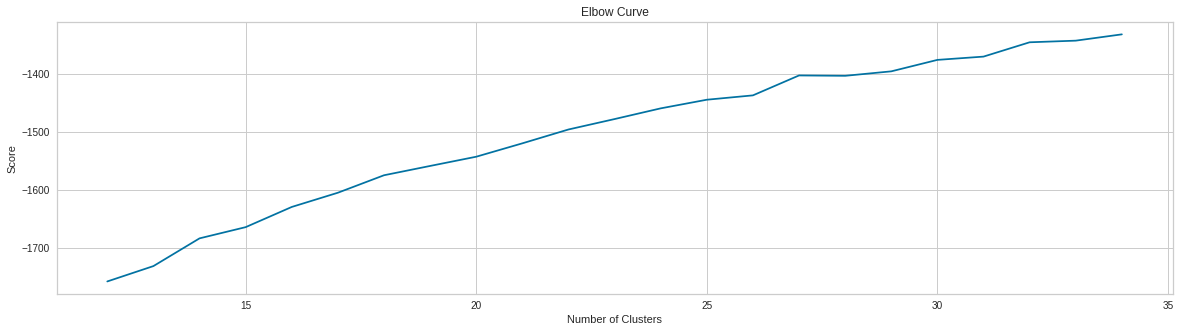

In [ ]:
Nc = range(12, 35)
kmeans = [KMeans(n_clusters=i).fit(features) for i in Nc]
kmeans
score = [model.score(features) for model in kmeans]
score
fig = plt.figure(figsize=(20,5))
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

##### <u>Kmeans aplication</u>

Clustering using k:12 - Same=44.26% - Diff:97.55%
Clustering using k:13 - Same=45.90% - Diff:96.93%
Clustering using k:14 - Same=40.98% - Diff:98.77%
Clustering using k:15 - Same=44.26% - Diff:98.16%
Clustering using k:16 - Same=42.62% - Diff:98.16%
Clustering using k:17 - Same=42.62% - Diff:98.16%
Clustering using k:18 - Same=42.62% - Diff:97.55%
Clustering using k:19 - Same=42.62% - Diff:98.16%
Clustering using k:20 - Same=40.98% - Diff:98.16%
Clustering using k:21 - Same=42.62% - Diff:99.39%
Clustering using k:22 - Same=42.62% - Diff:100.00%
Clustering using k:23 - Same=42.62% - Diff:99.39%
Clustering using k:24 - Same=44.26% - Diff:99.39%
Clustering using k:25 - Same=39.34% - Diff:99.39%
Clustering using k:26 - Same=39.34% - Diff:99.39%
Clustering using k:27 - Same=36.07% - Diff:98.77%
Clustering using k:28 - Same=40.98% - Diff:98.77%
Clustering using k:29 - Same=42.62% - Diff:100.00%
Clustering using k:30 - Same=39.34% - Diff:99.39%
Clustering using k:31 - Same=40.98% - Diff:99.39

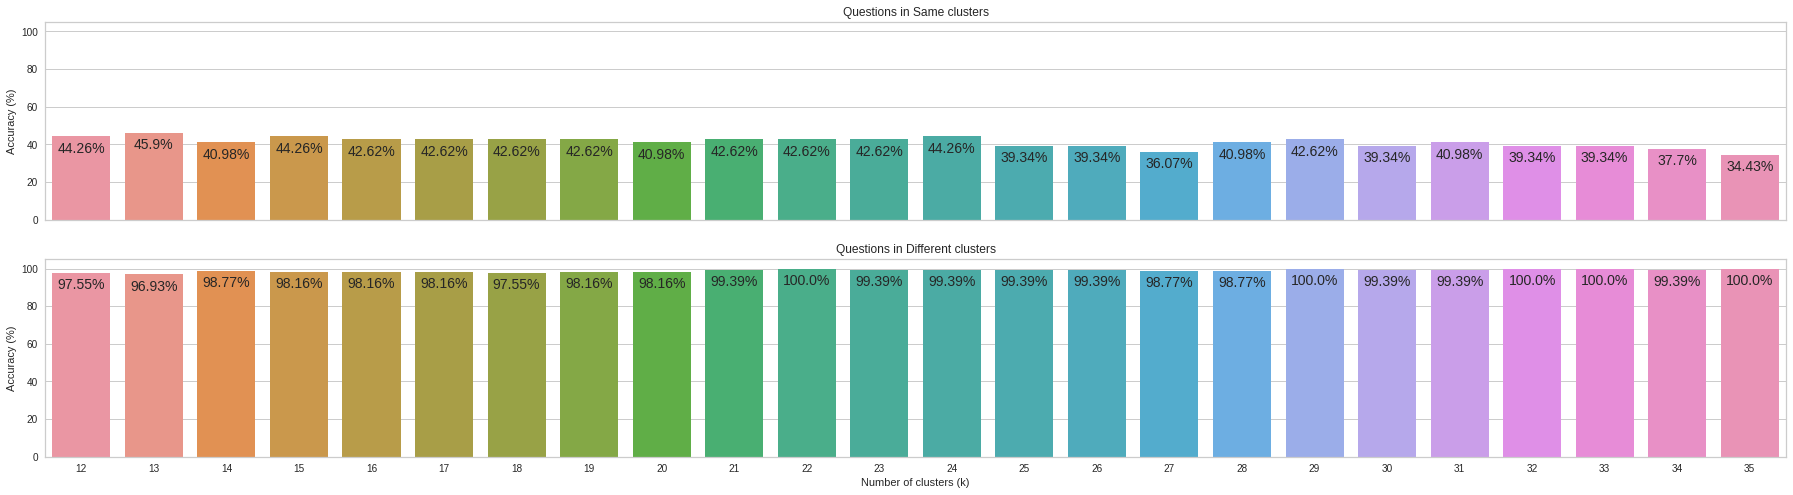

In [ ]:
# Evalue metrict using diferent k values
getClustersMetrics(corpus, features, k_init=12, k_end=35, debug=True)

Counter({3: 888, 4: 636, 0: 578, 8: 577, 16: 467, 7: 446, 9: 446, 15: 445, 5: 424, 12: 420, 18: 400, 22: 347, 11: 332, 14: 320, 6: 307, 2: 299, 13: 284, 21: 275, 1: 241, 17: 234, 10: 225, 19: 185, 23: 147, 20: 80})


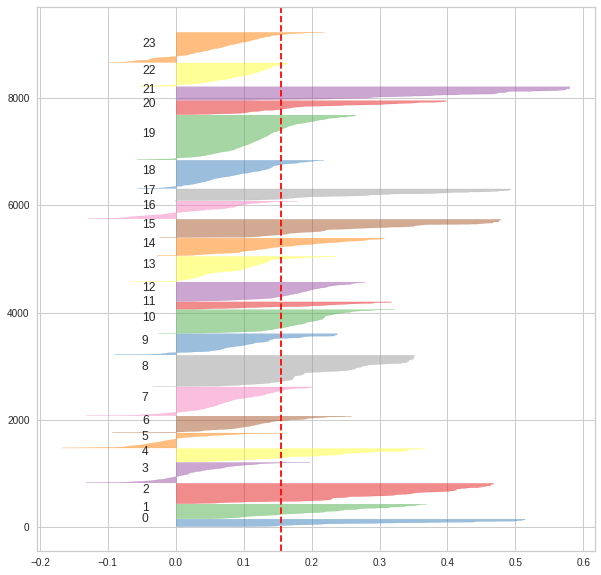

In [ ]:
# Run Kmeans model and generate Silhouette PLot to supervise the progress and select the optimal k value
km_model, data = myKmeans(corpus, features, k=24, max_iter=300, n_init=10)

# Silloute plot
silhouettePlot(km_model)

##### <u>Results:</u> 

In [ ]:
# Print questions for each clusters
getQuestionByClusters(data, 20)

# Draw clusters in 2d
clustersVisualizer(data, features, top=20)


[Cluster 0] --- 20 top questions
+--------------------------------------------------+--------------------------------------------+----------+
| question                                         | top_ans                                    |     dist |
|--------------------------------------------------+--------------------------------------------+----------|
| can you please describe this card?               | green person holding lantern walking stick | 0.170308 |
| describe this item.                              | bath shower gel                            | 0.170308 |
| identify this product.                           | brown sugar cinnamon pastry crisps         | 0.170308 |
| can you please describe this label?              | lotion                                     | 0.17711  |
| read this label.                                 | dermacol acne clear                        | 0.183396 |
| can you tell who put this one out?               | top chef                                 

### 5.2- Counter Matrix of (1-gram,2-gram,3-gram): **Question** + **All answers** (Qs lemmas without trivial information).

##### <u>Vectorization:</u>

In [ ]:
# Load corpus
corpus = pd.read_pickle(OUT_DFS_FOLDER+"wotinfo_corpus.pkl")

# Merge qs and ALL answers [CLS, qs, SEP, ans1, SEP, ans2, SEP, ansn, SEP]
qs_ans_list = list(zip(corpus.qs_lemmas_wotinfo.to_list(), corpus.ans_lemmas.to_list()))
print(*qs_ans_list[:10], sep="\n")
print("------> ")

qs_ans_list = [qs+[ans for ans_n in ans_list for ans in ans_n] for qs,ans_list in qs_ans_list]
print(*qs_ans_list[:10], sep="\n")

(['CLS', 'what', 'be', 'the', 'name', 'of', 'this', 'product', 'SEP'], [['basil', 'leave', 'SEP'], ['basil', 'SEP']])
(['CLS', 'what', 'be', 'in', 'this', 'can', 'please', 'SEP'], [['coca', 'cola', 'SEP'], ['unsuitable', 'SEP'], ['coke', '0', 'SEP'], ['soda', 'SEP'], ['coca', 'cola', '0', 'SEP'], ['coke', 'SEP']])
(['CLS', 'what', 'be', 'the', 'captcha', 'on', 'this', 'screenshot', 'SEP'], [['t36', 'm', 'SEP'], ['t', '3', '6', 'm', 'SEP'], ['t63', 'm', 'SEP']])
(['CLS', 'what', 'be', 'this', 'item', 'SEP'], [['solar', 'garden', 'light', 'SEP'], ['solar', 'light', 'SEP'], ['garden', 'light', 'SEP']])
(['CLS', 'what', 'be', 'this', 'SEP'], [['shoe', 'SEP'], ['boot', 'SEP'], ['foot', 'SEP'], ['unanswerable', 'SEP'], ['someone', 'foot', 'SEP']])
(['CLS', 'what', 'be', 'in', 'this', 'bottle', 'SEP'], [['mouthwash', 'SEP'], ['mouthrinse', 'SEP'], ['antiseptic', 'mouthrinse', 'SEP'], ['advanced', 'antiseptic', 'mouthwash', 'tartar', 'protection', 'citrus', 'flavor', 'SEP']])
(['CLS', 'this', 

In [ ]:
def my_preprocessor(text):
    return text

def my_tokenizer(text):
    # Nothing. The input is alredy a list of tokens
    return text

# Get features matrix
cv = CountVectorizer(   tokenizer=my_tokenizer, 
                        preprocessor=my_preprocessor, 
                        ngram_range=(1,3), min_df=10)

features = cv.fit_transform(qs_ans_list).toarray()

# Normalization y reduction
features = normAndReduction(features, _threshold_var=.001, _reduction=True)

Features dimensionality post Normalization: (9003, 4211)
Post (Norm + Dimensionality reduction): (9003, 74)


##### <u>Kmeans aplication:</u>

Clustering using k:12 - Same=27.87% - Diff:89.57%
Clustering using k:13 - Same=24.59% - Diff:93.25%
Clustering using k:14 - Same=22.95% - Diff:90.80%
Clustering using k:15 - Same=18.03% - Diff:94.48%
Clustering using k:16 - Same=21.31% - Diff:91.41%
Clustering using k:17 - Same=24.59% - Diff:93.87%
Clustering using k:18 - Same=26.23% - Diff:93.25%
Clustering using k:19 - Same=27.87% - Diff:94.48%
Clustering using k:20 - Same=21.31% - Diff:94.48%
Clustering using k:21 - Same=22.95% - Diff:96.32%
Clustering using k:22 - Same=22.95% - Diff:96.93%
Clustering using k:23 - Same=18.03% - Diff:95.09%
Clustering using k:24 - Same=19.67% - Diff:95.71%
Clustering using k:25 - Same=26.23% - Diff:96.93%
Clustering using k:26 - Same=18.03% - Diff:97.55%
Clustering using k:27 - Same=16.39% - Diff:96.93%
Clustering using k:28 - Same=19.67% - Diff:97.55%
Clustering using k:29 - Same=18.03% - Diff:98.16%
Clustering using k:30 - Same=21.31% - Diff:98.16%
Clustering using k:31 - Same=14.75% - Diff:98.16%


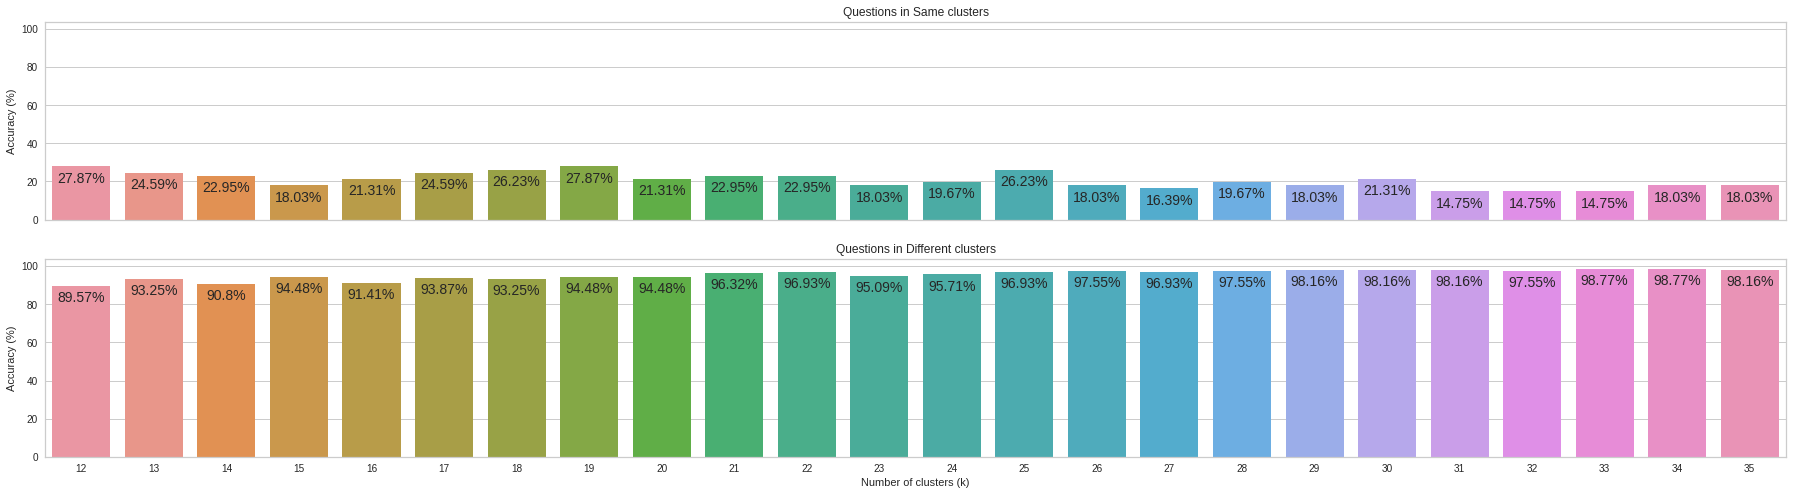

In [ ]:
# Evalue metrict using diferent k values
getClustersMetrics(corpus, features, k_init=12, k_end=35, debug=True)

Counter({13: 817, 7: 764, 21: 685, 5: 647, 8: 507, 18: 500, 9: 460, 20: 425, 10: 383, 15: 351, 3: 316, 14: 315, 1: 301, 22: 295, 4: 291, 2: 271, 11: 258, 16: 251, 23: 214, 0: 185, 6: 174, 19: 163, 12: 155, 24: 143, 17: 132})


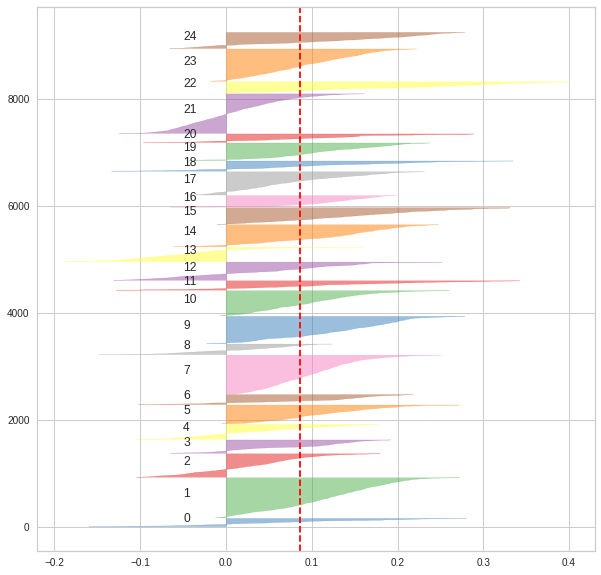

In [ ]:
# Run Kmeans model and generate Silhouette PLot to supervise the progress and select the optimal k value
km_model, data = myKmeans(corpus, features, k=25, max_iter=300, n_init=10)

# Silloute plot
silhouettePlot(km_model)

##### <u>Results:</u> 

In [ ]:
# Print questions for each clusters
getQuestionByClusters(data, 20)

# Draw clusters in 2d
clustersVisualizer(data, features, top=20)


[Cluster 0] --- 20 top questions
+------------------------------------------------------------+---------------------+----------+
| question                                                   | top_ans             |     dist |
|------------------------------------------------------------+---------------------+----------|
| are these sausages fully cooked?                           | yes                 | 0.206523 |
| is it possible to tell which product this is?              | coconut body butter | 0.219315 |
| is there any text on my computer screen?                   | yes                 | 0.229236 |
| is there any writing on this dressing packet?              | yes                 | 0.236063 |
| are these regular potato chips, or salt and vinegar chips? | salt vinegar        | 0.240214 |
| this is product.                                           | tomato soup         | 0.243135 |
| can you read the title of this book?                       | mistresses dark     | 0.246532 |
| can 

### 5.3- Doc2Vec: **Question** + **Most matching answer** (Qs lemmas without trivial information)

##### <u>Vectorization:</u>

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Load corpus
corpus = pd.read_pickle(OUT_DFS_FOLDER+"wotinfo_corpus.pkl")

# Merge qs and ALL answers [CLS, qs, SEP, ans1, SEP, ans2, SEP, ansn, SEP]
qs_ans_list = list(zip(corpus.qs_lemmas_wotinfo.to_list(), corpus.ans_lemmas.to_list()))
print(*qs_ans_list[:10], sep="\n")
print("------> ")

qs_ans_list = [qs+[ans for ans in ans_list[0]] for qs,ans_list in qs_ans_list]
print(*qs_ans_list[:10], sep="\n")

(['CLS', 'what', 'be', 'the', 'name', 'of', 'this', 'product', 'SEP'], [['basil', 'leave', 'SEP'], ['basil', 'SEP']])
(['CLS', 'what', 'be', 'in', 'this', 'can', 'please', 'SEP'], [['coca', 'cola', 'SEP'], ['unsuitable', 'SEP'], ['coke', '0', 'SEP'], ['soda', 'SEP'], ['coca', 'cola', '0', 'SEP'], ['coke', 'SEP']])
(['CLS', 'what', 'be', 'the', 'captcha', 'on', 'this', 'screenshot', 'SEP'], [['t36', 'm', 'SEP'], ['t', '3', '6', 'm', 'SEP'], ['t63', 'm', 'SEP']])
(['CLS', 'what', 'be', 'this', 'item', 'SEP'], [['solar', 'garden', 'light', 'SEP'], ['solar', 'light', 'SEP'], ['garden', 'light', 'SEP']])
(['CLS', 'what', 'be', 'this', 'SEP'], [['shoe', 'SEP'], ['boot', 'SEP'], ['foot', 'SEP'], ['unanswerable', 'SEP'], ['someone', 'foot', 'SEP']])
(['CLS', 'what', 'be', 'in', 'this', 'bottle', 'SEP'], [['mouthwash', 'SEP'], ['mouthrinse', 'SEP'], ['antiseptic', 'mouthrinse', 'SEP'], ['advanced', 'antiseptic', 'mouthwash', 'tartar', 'protection', 'citrus', 'flavor', 'SEP']])
(['CLS', 'this', 

In [ ]:
# Prepare date to build model
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(qs_ans_list)]

# Train model
model = Doc2Vec(documents=documents, vector_size=100, window=4, min_count=1, workers=4)

# Get vector for each documents
features = pd.DataFrame(np.array([model.docvecs[n] for n in range(len(model.docvecs))]))

##### <u>Kmeans aplication:</u>

Clustering using k:12 - Same=18.03% - Diff:88.34%
Clustering using k:13 - Same=18.03% - Diff:87.73%
Clustering using k:14 - Same=11.48% - Diff:84.66%
Clustering using k:15 - Same=6.56% - Diff:87.12%
Clustering using k:16 - Same=13.11% - Diff:89.57%
Clustering using k:17 - Same=11.48% - Diff:87.73%
Clustering using k:18 - Same=14.75% - Diff:87.73%
Clustering using k:19 - Same=6.56% - Diff:88.34%
Clustering using k:20 - Same=11.48% - Diff:90.80%
Clustering using k:21 - Same=8.20% - Diff:90.18%
Clustering using k:22 - Same=8.20% - Diff:90.80%
Clustering using k:23 - Same=9.84% - Diff:93.87%
Clustering using k:24 - Same=9.84% - Diff:92.64%
Clustering using k:25 - Same=9.84% - Diff:92.64%
Clustering using k:26 - Same=8.20% - Diff:92.02%
Clustering using k:27 - Same=8.20% - Diff:91.41%
Clustering using k:28 - Same=4.92% - Diff:93.87%
Clustering using k:29 - Same=6.56% - Diff:90.80%
Clustering using k:30 - Same=6.56% - Diff:93.87%


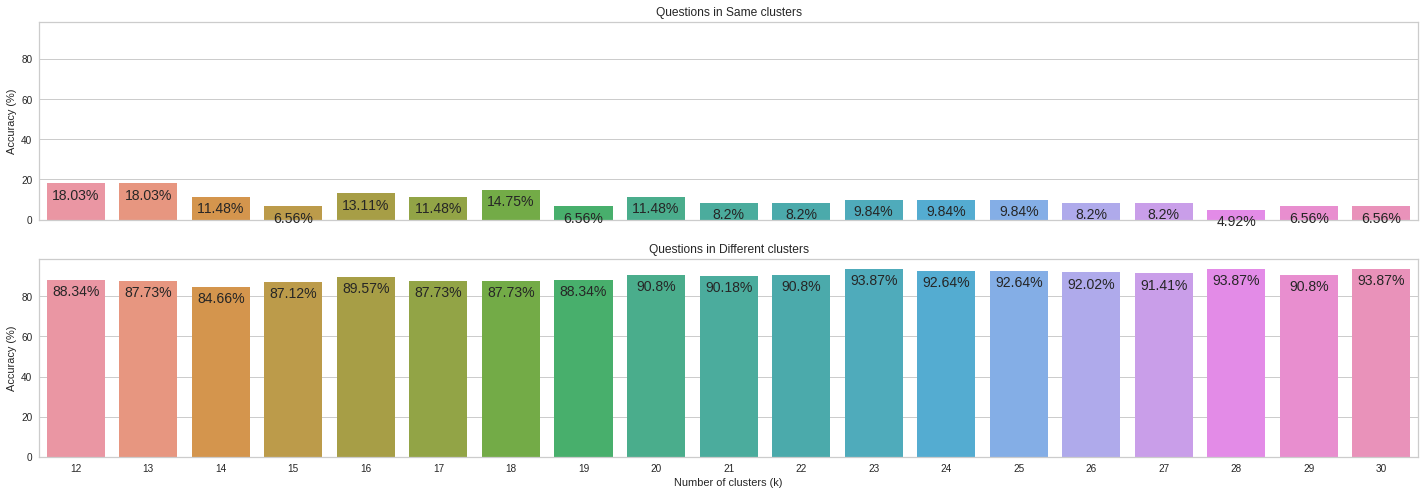

In [ ]:
# Evalue metrict using diferent k values
getClustersMetrics(corpus, features, k_init=12, k_end=30, debug=True)

Counter({7: 974, 12: 948, 0: 924, 9: 888, 16: 843, 6: 803, 13: 703, 2: 589, 14: 586, 8: 460, 3: 332, 17: 317, 1: 226, 10: 163, 15: 128, 5: 69, 11: 39, 4: 11})


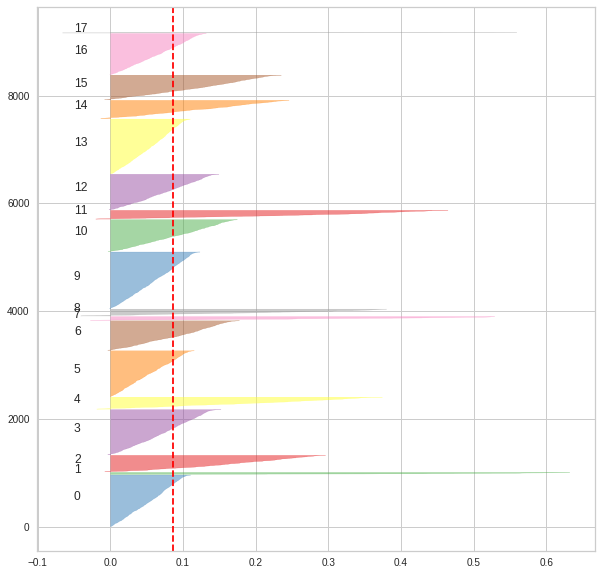

In [ ]:
# Run Kmeans model and generate Silhouette PLot to supervise the progress and select the optimal k value
km_model, data = myKmeans(corpus, features, k=18, max_iter=300, n_init=10)

# Silloute plot
silhouettePlot(km_model)

##### <u>Results:</u> 

In [ ]:
# Print questions for each clusters
getQuestionByClusters(data, 20)

# Draw clusters in 2d
clustersVisualizer(data, features, top=20)


[Cluster 0] --- 20 top questions
+-----------------------------------------------------------+--------------+-----------+
| question                                                  | top_ans      |      dist |
|-----------------------------------------------------------+--------------+-----------|
| what is that that i just took a picture of?               | moon         | 0.025112  |
| how long do i bake this for and what temperature?         | unanswerable | 0.0255431 |
| what is this beer?                                        | harp lager   | 0.0258866 |
| please tell me the instructions on this shampoo bottle.   | unsuitable   | 0.0258979 |
| is there a newspaper on the table?                        | no           | 0.025899  |
| are my clothes dirty?                                     | no           | 0.0260134 |
| are there any fleas on my dog?                            | no           | 0.0262504 |
| what medication is this?                                  | unsuitable   |

### 5.3- Doc2Vec: **Question** + **All answer** (Qs lemmas without trivial information)

##### <u>Vectorization:</u>

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Load corpus
corpus = pd.read_pickle(OUT_DFS_FOLDER+"wotinfo_corpus.pkl")

# Merge qs and ALL answers [CLS, qs, SEP, ans1, SEP, ans2, SEP, ansn, SEP]
qs_ans_list = list(zip(corpus.qs_lemmas_wotinfo.to_list(), corpus.ans_lemmas.to_list()))
print(*qs_ans_list[:10], sep="\n")
print("------> ")

qs_ans_list = [qs+[ans for ans_n in ans_list for ans in ans_n] for qs,ans_list in qs_ans_list]
print(*qs_ans_list[:10], sep="\n")

(['CLS', 'what', 'be', 'the', 'name', 'of', 'this', 'product', 'SEP'], [['basil', 'leave', 'SEP'], ['basil', 'SEP']])
(['CLS', 'what', 'be', 'in', 'this', 'can', 'please', 'SEP'], [['coca', 'cola', 'SEP'], ['unsuitable', 'SEP'], ['coke', '0', 'SEP'], ['soda', 'SEP'], ['coca', 'cola', '0', 'SEP'], ['coke', 'SEP']])
(['CLS', 'what', 'be', 'the', 'captcha', 'on', 'this', 'screenshot', 'SEP'], [['t36', 'm', 'SEP'], ['t', '3', '6', 'm', 'SEP'], ['t63', 'm', 'SEP']])
(['CLS', 'what', 'be', 'this', 'item', 'SEP'], [['solar', 'garden', 'light', 'SEP'], ['solar', 'light', 'SEP'], ['garden', 'light', 'SEP']])
(['CLS', 'what', 'be', 'this', 'SEP'], [['shoe', 'SEP'], ['boot', 'SEP'], ['foot', 'SEP'], ['unanswerable', 'SEP'], ['someone', 'foot', 'SEP']])
(['CLS', 'what', 'be', 'in', 'this', 'bottle', 'SEP'], [['mouthwash', 'SEP'], ['mouthrinse', 'SEP'], ['antiseptic', 'mouthrinse', 'SEP'], ['advanced', 'antiseptic', 'mouthwash', 'tartar', 'protection', 'citrus', 'flavor', 'SEP']])
(['CLS', 'this', 

In [ ]:
# Prepare date to build model
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(qs_ans_list)]
# print(*documents, sep="\n")

# Train model
model = Doc2Vec(documents=documents, vector_size=100, window=4, min_count=1, workers=4)

# Get vector for each documents
features = pd.DataFrame(np.array([model.docvecs[n] for n in range(len(model.docvecs))]))

##### <u>Kmeans aplication:</u>

Clustering using k:12 - Same=27.87% - Diff:85.89%
Clustering using k:13 - Same=31.15% - Diff:87.73%
Clustering using k:14 - Same=29.51% - Diff:90.80%
Clustering using k:15 - Same=26.23% - Diff:89.57%
Clustering using k:16 - Same=21.31% - Diff:88.96%
Clustering using k:17 - Same=21.31% - Diff:91.41%
Clustering using k:18 - Same=16.39% - Diff:92.64%
Clustering using k:19 - Same=13.11% - Diff:92.02%
Clustering using k:20 - Same=16.39% - Diff:93.87%
Clustering using k:21 - Same=11.48% - Diff:92.64%
Clustering using k:22 - Same=14.75% - Diff:91.41%
Clustering using k:23 - Same=16.39% - Diff:94.48%
Clustering using k:24 - Same=13.11% - Diff:92.02%
Clustering using k:25 - Same=11.48% - Diff:92.02%
Clustering using k:26 - Same=9.84% - Diff:95.09%
Clustering using k:27 - Same=6.56% - Diff:93.87%
Clustering using k:28 - Same=11.48% - Diff:95.71%
Clustering using k:29 - Same=11.48% - Diff:95.09%
Clustering using k:30 - Same=16.39% - Diff:94.48%


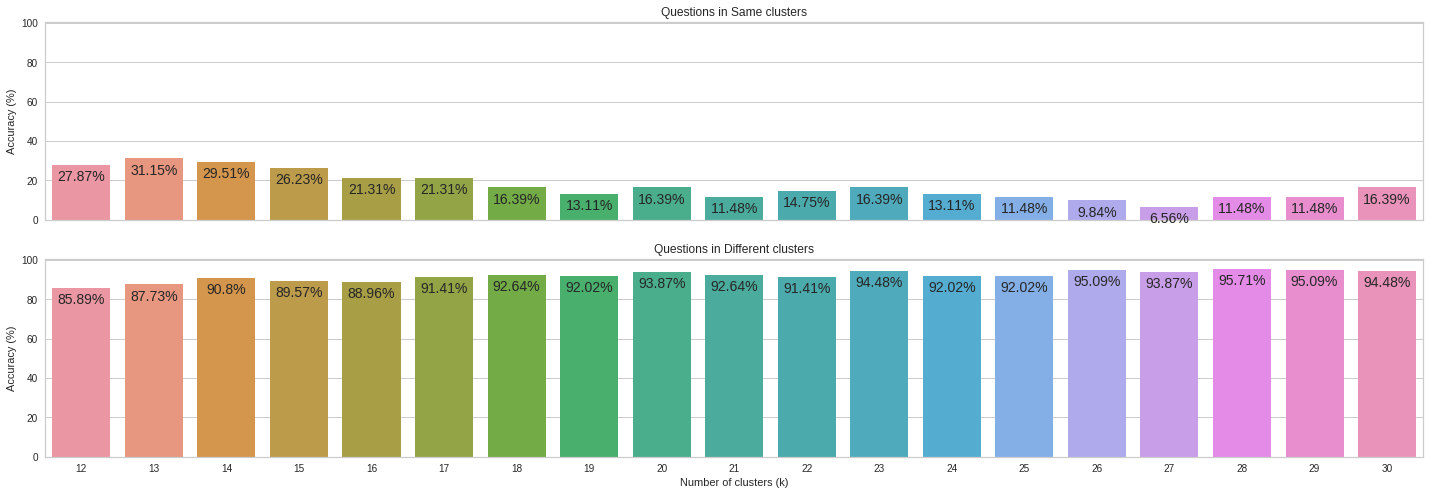

In [ ]:
# Evalue metrict using diferent k values
getClustersMetrics(corpus, features, k_init=12, k_end=30, debug=True)

Counter({13: 1791, 12: 1727, 2: 1100, 10: 890, 3: 812, 11: 644, 1: 550, 7: 396, 5: 365, 0: 303, 9: 205, 6: 102, 8: 94, 4: 24})


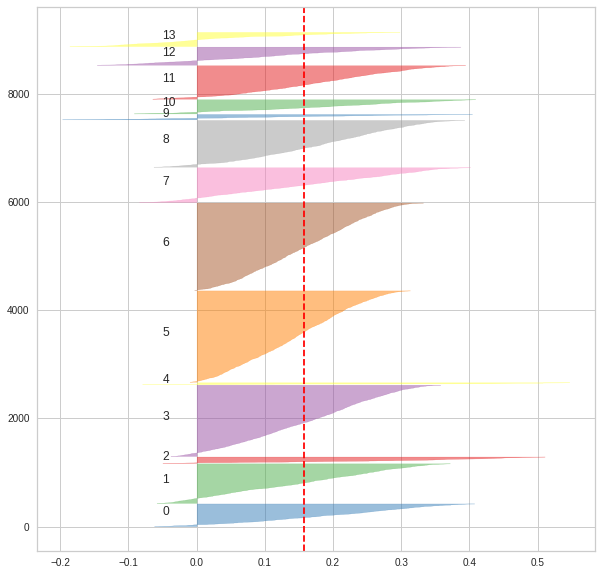

In [ ]:
# Run Kmeans model and generate Silhouette PLot to supervise the progress and select the optimal k value
km_model, data = myKmeans(corpus, features, k=14, max_iter=300, n_init=10)

# Silloute plot
silhouettePlot(km_model)

##### <u>Results:</u> 

In [ ]:
# Print questions for each clusters
getQuestionByClusters(data, 20)

# Draw clusters in 2d
clustersVisualizer(data, features, top=20)


[Cluster 0] --- 20 top questions
+----------------------------------------------------+--------------+-----------+
| question                                           | top_ans      |      dist |
|----------------------------------------------------+--------------+-----------|
| what color is the cat?                             | orange white | 0.0284031 |
| what color is this rose leaf?                      | unanswerable | 0.0356875 |
| what color is the rope?                            | blue         | 0.0369461 |
| what color is the wall?                            | tan          | 0.0392372 |
| color is this stone                                | unanswerable | 0.0397395 |
| can you tell me what color these pants are?        | blue         | 0.0407194 |
| is this blue or purple?                            | blue         | 0.0409555 |
| what color is this hair clip?                      | gold         | 0.0430468 |
| what color is the shower curtain?                  | orange   

### 5.4 FastText: **Question** + **All answer** (Qs lemmas without trivial information)

#### <u>Vectorization:</u>

In [ ]:
from gensim.models import FastText
from gensim.test.utils import common_texts  # some example sentences

# Load corpus
corpus = pd.read_pickle(OUT_DFS_FOLDER+"wotinfo_corpus.pkl")

# Merge qs and ALL answers [CLS, qs, SEP, ans1, SEP, ans2, SEP, ansn, SEP]
qs_ans_list = list(zip(corpus.qs_lemmas_wotinfo.to_list(), corpus.ans_lemmas.to_list()))
print(*qs_ans_list[:10], sep="\n")
print("------> ")

# qs_ans_list = [qs+[ans for ans in ans_list[0]] for qs,ans_list in qs_ans_list]                # Most matching answer
qs_ans_list = [qs+[ans for ans_n in ans_list for ans in ans_n] for qs,ans_list in qs_ans_list]  # All answers
print(*qs_ans_list[:10], sep="\n")

(['CLS', 'what', 'be', 'the', 'name', 'of', 'this', 'product', 'SEP'], [['basil', 'leave', 'SEP'], ['basil', 'SEP']])
(['CLS', 'what', 'be', 'in', 'this', 'can', 'please', 'SEP'], [['coca', 'cola', 'SEP'], ['unsuitable', 'SEP'], ['coke', '0', 'SEP'], ['soda', 'SEP'], ['coca', 'cola', '0', 'SEP'], ['coke', 'SEP']])
(['CLS', 'what', 'be', 'the', 'captcha', 'on', 'this', 'screenshot', 'SEP'], [['t36', 'm', 'SEP'], ['t', '3', '6', 'm', 'SEP'], ['t63', 'm', 'SEP']])
(['CLS', 'what', 'be', 'this', 'item', 'SEP'], [['solar', 'garden', 'light', 'SEP'], ['solar', 'light', 'SEP'], ['garden', 'light', 'SEP']])
(['CLS', 'what', 'be', 'this', 'SEP'], [['shoe', 'SEP'], ['boot', 'SEP'], ['foot', 'SEP'], ['unanswerable', 'SEP'], ['someone', 'foot', 'SEP']])
(['CLS', 'what', 'be', 'in', 'this', 'bottle', 'SEP'], [['mouthwash', 'SEP'], ['mouthrinse', 'SEP'], ['antiseptic', 'mouthrinse', 'SEP'], ['advanced', 'antiseptic', 'mouthwash', 'tartar', 'protection', 'citrus', 'flavor', 'SEP']])
(['CLS', 'this', 

In [ ]:
# Train model using fastText
ft_model = FastText(size=100, window=4, min_count=1, iter=10) # iter = epochs
ft_model.build_vocab(sentences=qs_ans_list)
ft_model.train(sentences=qs_ans_list, total_words=ft_model.corpus_total_words, epochs=ft_model.epochs)

# Add columns with word embedding list by each lemma of question
df = corpus[['question', 'answers']]
df = df.assign(embedding_list = [ft_model.wv[tk] for tk in qs_ans_list] )

#### Sum embedding -> Normalization

In [ ]:
# Get embedding vector result througth elemen-wise operations (sum and multiplication)
def vecSum(vec_array):
    return np.sum(vec_array, axis=0)
    
# Get result embedding vector
_df = df.assign(embedding_res = df.embedding_list.progress_apply(lambda l: vecSum(l)))
features = pd.DataFrame(np.array(_df.embedding_res.to_list()))

# Normalization
features = normAndReduction(features, _threshold_var=.001, _reduction=False)

100%|██████████| 9003/9003 [00:00<00:00, 111167.00it/s]

Features dimensionality post Normalization: (9003, 100)


##### - <u>Kmeans aplication:</u>

Clustering using k:12 - Same=18.03% - Diff:92.64%
Clustering using k:13 - Same=19.67% - Diff:93.25%
Clustering using k:14 - Same=18.03% - Diff:93.25%
Clustering using k:15 - Same=16.39% - Diff:90.80%
Clustering using k:16 - Same=11.48% - Diff:91.41%
Clustering using k:17 - Same=11.48% - Diff:91.41%
Clustering using k:18 - Same=8.20% - Diff:90.80%
Clustering using k:19 - Same=13.11% - Diff:92.02%
Clustering using k:20 - Same=11.48% - Diff:92.64%
Clustering using k:21 - Same=13.11% - Diff:97.55%
Clustering using k:22 - Same=11.48% - Diff:95.09%
Clustering using k:23 - Same=9.84% - Diff:97.55%
Clustering using k:24 - Same=13.11% - Diff:96.93%
Clustering using k:25 - Same=9.84% - Diff:96.32%
Clustering using k:26 - Same=8.20% - Diff:95.71%
Clustering using k:27 - Same=9.84% - Diff:96.93%
Clustering using k:28 - Same=8.20% - Diff:98.16%
Clustering using k:29 - Same=11.48% - Diff:98.16%
Clustering using k:30 - Same=4.92% - Diff:97.55%


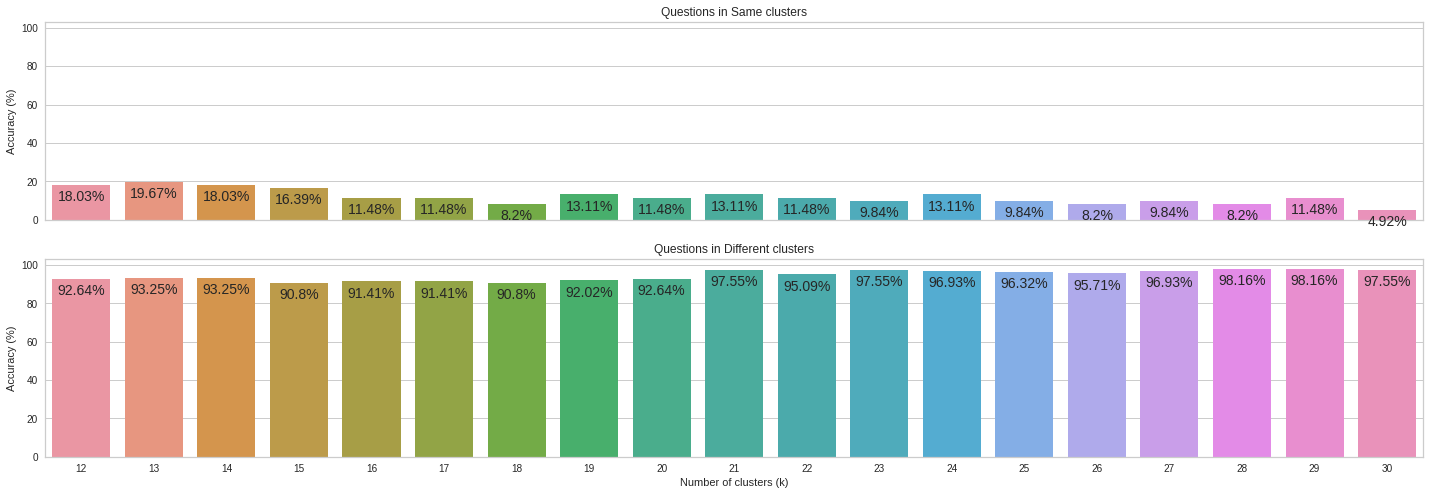

In [ ]:
# Evalue metrict using diferent k values
getClustersMetrics(corpus, features, k_init=12, k_end=30, debug=True)

Counter({20: 722, 0: 656, 17: 651, 12: 557, 7: 556, 2: 544, 5: 502, 4: 496, 11: 484, 13: 428, 8: 407, 10: 396, 14: 395, 18: 380, 9: 350, 16: 302, 6: 297, 3: 272, 1: 233, 15: 200, 19: 175})


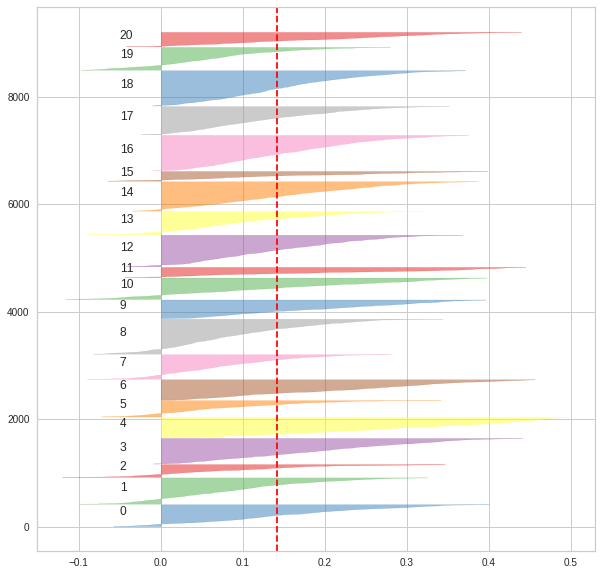

In [ ]:
# Run Kmeans model and generate Silhouette PLot to supervise the progress and select the optimal k value
km_model, data = myKmeans(corpus, features, k=21, max_iter=300, n_init=10)

# Silloute plot
silhouettePlot(km_model)

##### - <u>Results:</u> 

In [ ]:
# Print questions for each clusters
getQuestionByClusters(data, 20)

# Draw clusters in 2d
clustersVisualizer(data, features, top=20)


[Cluster 0] --- 20 top questions
+---------------------------------------------------------------------+------------------+-----------+
| question                                                            | top_ans          |      dist |
|---------------------------------------------------------------------+------------------+-----------|
| what is this show on the screen?                                    | unanswerable     | 0.0881874 |
| can you tell what information is on the bus stop?                   | no               | 0.10417   |
| what is the code in my hand?                                        | unanswerable     | 0.115371  |
| what is shown in the little rectangular window?                     | unsuitable       | 0.115386  |
| what is the three digit verification number?                        | unanswerable     | 0.115598  |
| what is the picture on this box, or words?                          | unsuitable       | 0.116055  |
| what is the date on this paper?      

#### Multiplication embedding -> Normalization

In [ ]:
# Get embedding vector result througth elemen-wise operations (sum and multiplication)
def vecMult(vec_array):
    vec_res = vec_array[0]
    for vec in vec_array[1:]:
        vec_res = np.multiply(vec_res,vec)
    return vec_res

# Get result embedding vector
_df = df.assign(embedding_res = df.embedding_list.progress_apply(lambda l: vecMult(l)))
features = pd.DataFrame(np.array(_df.embedding_res.to_list()))

# Normalization
features = normAndReduction(features, _threshold_var=.001, _reduction=False)

100%|██████████| 9003/9003 [00:00<00:00, 35700.30it/s]

Features dimensionality post Normalization: (9003, 100)


##### <u>Kmeans aplication:</u>

Clustering using k:12 - Same=22.95% - Diff:85.89%
Clustering using k:13 - Same=22.95% - Diff:85.28%
Clustering using k:14 - Same=24.59% - Diff:87.12%
Clustering using k:15 - Same=21.31% - Diff:87.12%
Clustering using k:16 - Same=24.59% - Diff:87.73%
Clustering using k:17 - Same=22.95% - Diff:87.73%
Clustering using k:18 - Same=21.31% - Diff:87.73%
Clustering using k:19 - Same=21.31% - Diff:87.73%
Clustering using k:20 - Same=21.31% - Diff:87.73%
Clustering using k:21 - Same=21.31% - Diff:87.73%
Clustering using k:22 - Same=21.31% - Diff:87.73%
Clustering using k:23 - Same=19.67% - Diff:88.96%
Clustering using k:24 - Same=21.31% - Diff:90.18%
Clustering using k:25 - Same=21.31% - Diff:88.34%
Clustering using k:26 - Same=21.31% - Diff:87.73%
Clustering using k:27 - Same=19.67% - Diff:88.96%
Clustering using k:28 - Same=21.31% - Diff:87.73%
Clustering using k:29 - Same=19.67% - Diff:87.73%
Clustering using k:30 - Same=19.67% - Diff:87.12%


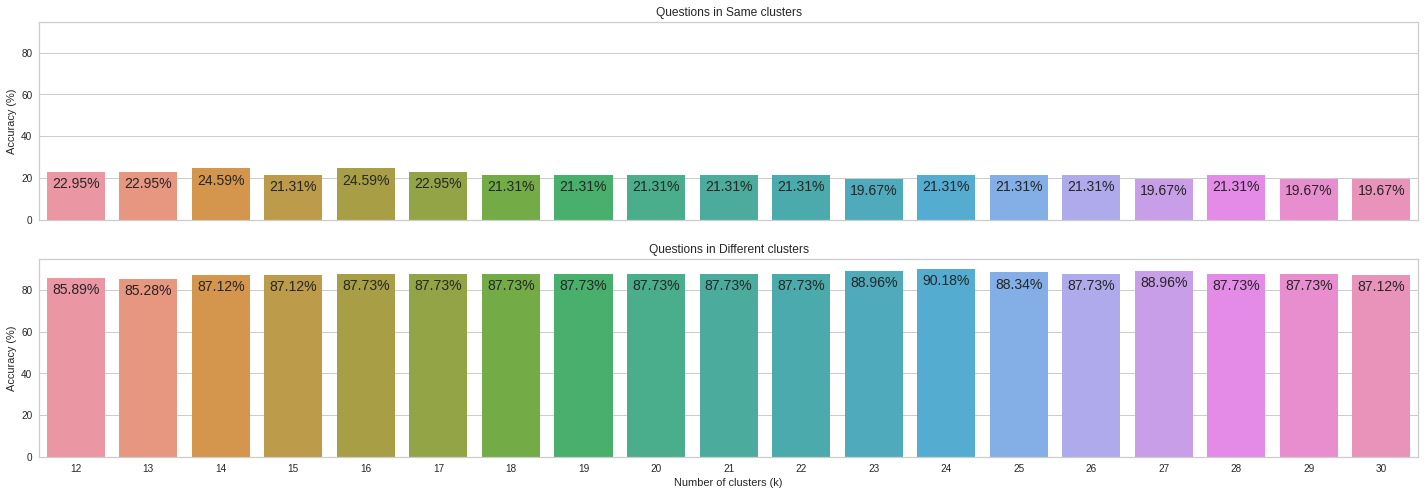

In [ ]:
# Evalue metrict using diferent k values
getClustersMetrics(corpus, features, k_init=12, k_end=30, debug=True)

Counter({0: 3105, 9: 700, 5: 611, 3: 579, 4: 554, 8: 495, 2: 384, 15: 380, 6: 370, 7: 353, 10: 347, 14: 305, 13: 266, 12: 264, 11: 152, 1: 138})


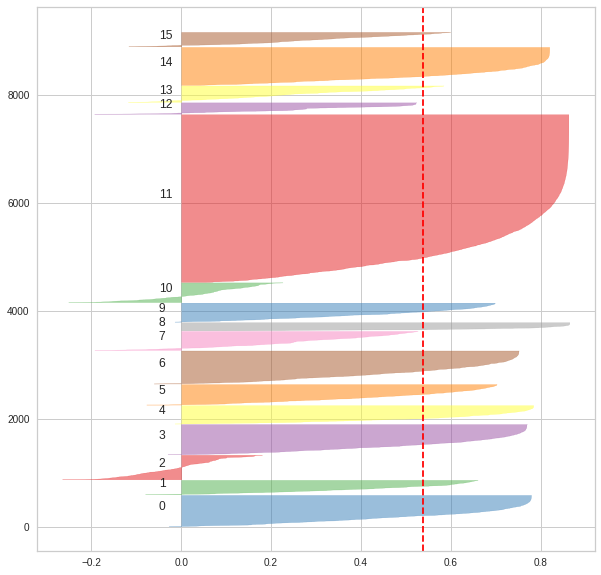

In [ ]:
# Run Kmeans model and generate Silhouette PLot to supervise the progress and select the optimal k value
km_model, data = myKmeans(corpus, features, k=16, max_iter=300, n_init=10)

# Silloute plot
silhouettePlot(km_model)

##### <u>Results:</u> 

In [ ]:
# Print questions for each clusters
getQuestionByClusters(data, 20)

# Draw clusters in 2d
clustersVisualizer(data, features, top=20)


[Cluster 0] --- 20 top questions
+-------------------------------------------------+--------------+-----------+
| question                                        | top_ans      |      dist |
|-------------------------------------------------+--------------+-----------|
| what do you see in this video?                  | unsuitable   | 0.041497  |
| what is under the word fairbanks on this magnet | unsuitable   | 0.0414977 |
| what is this photo taken of?                    | laptop       | 0.0415321 |
| what kind of chapstick is this?                 | unanswerable | 0.041662  |
| what color is this plant?                       | green        | 0.0416655 |
| tell me what is in this photo?                  | unsuitable   | 0.0417004 |
| what color is this pass?                        | khaki        | 0.0417034 |
| this symbol on this shirt.                      | unanswerable | 0.0417148 |
| can you tell what kind of animal this is?       | squirrel     | 0.0417153 |
| what color is th